## Instalando pacotes

In [16]:
! pip install stringdb networkx matplotlib graphviz biopython
import stringdb
import networkx as nx
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.3 MB 2.3 MB/s eta 0:00:01


## Coletando dados de enzimas com um dado EC

In [ ]:
from Bio.KEGG import REST
from Bio.KEGG import Enzyme
request = REST.kegg_get("ec:2.7.7.9")
open("ec_2.7.7.9.txt", "w").write(request.read())
records = Enzyme.parse(open("ec_2.7.7.9.txt"))
record = list(records)[0]
print(record.classname)
print(record.entry)

['Transferases;', 'Transferring phosphorus-containing groups;', 'Nucleotidyltransferases']
2.7.7.9


## Obter todos os genes relacionados com a via metabólica de'vitamina C

In [ ]:
from Bio.KEGG import REST

human_pathways = REST.kegg_list("pathway", "hsa").read()

# Filtar para humanos, Ascorbate
Ascorbate_pathways = []
for line in human_pathways.rstrip().split("\n"):
    entry, description = line.split("\t")
    if "Ascorbate" in description:
        Ascorbate_pathways.append(entry)

# Pegar genes da via de Ascorbate e adicionar em uma lista
Ascorbate_genes = [] 
for pathway in Ascorbate_pathways:
    pathway_file = REST.kegg_get(pathway).read()  # for each pathway

    # Percorrer o pathway
    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # nomes na 12a coluna
        if not section == "":
            current_section = section
        
        if current_section == "GENE":
            gene_identifiers, gene_description = line[12:].split("; ")
            gene_id, gene_symbol = gene_identifiers.split()

            if not gene_symbol in Ascorbate_genes:
                Ascorbate_genes.append(gene_symbol)

print("Existe(m) %d vias de Ascorbate e %d genes relacionados:" % \
      (len(Ascorbate_pathways), len(Ascorbate_genes)))
print(", ".join(Ascorbate_genes)) 

Existe(m) 1 vias de Ascorbate e 30 genes relacionados.\ OS genes são:
UGDH, UGT2A1, UGT2A3, UGT2B17, UGT2B11, UGT2B28, UGT1A6, UGT1A4, UGT1A1, UGT1A3, UGT2B10, UGT1A9, UGT2B7, UGT1A10, UGT1A8, UGT1A5, UGT2B15, UGT1A7, UGT2B4, UGT2A2, GUSB, KL, MIOX, AKR1A1, RGN, ALDH2, ALDH3A2, ALDH1B1, ALDH7A1, ALDH9A1


In [70]:
from Bio import Entrez
Entrez.email = "email@example.com"     # Always tell NCBI who you are
handle = Entrez.esearch(db="gene", term="human[Orgn] AND UGT2A1[Gene]", idtype="acc", retmax="1") 
record = Entrez.read(handle)
if int(record['Count']) > 0:
    print(f"ID: {record['IdList'][0]}")
    id = record['IdList'][0]

ID: 10941


## Obter sequência de um dos genes da enzima UTP---glucose-1-phosphate uridylyltransferase (UGT2A1)


In [89]:
# Combinacoes possiveis de rettype  retmode
# https://www.ncbi.nlm.nih.gov/books/NBK25499/table/chapter4.T._valid_values_of__retmode_and/?report=objectonly
base = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?"
banco = "db=gene&"
id_sequencia = f"id={id}&"
rettype = "rettype=gene_table&"
retmode = "retmode=text" 
url = base+banco+id_sequencia+rettype+retmode
print(url)
import requests
seq = requests.get(url)
print(seq.text)

https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=gene&id=10941&rettype=gene_table&retmode=text
UGT2A1 UDP glucuronosyltransferase family 2 member A1 complex locus[Homo sapiens]
Gene ID: 10941, updated on 13-May-2022


Reference GRCh38.p14 Primary Assembly NC_000004.12  (minus strand) from: 69653247 to: 69588417
mRNA transcript variant 4 NM_001301239.2, 6 exons,  total annotated spliced exon length: 2521
protein isoform 4 precursor NP_001288168.1 (CCDS77925.1), 5 coding  exons,  annotated AA length: 483

Exon table for  mRNA  NM_001301239.2 and protein NP_001288168.1
Genomic Interval Exon		Genomic Interval Coding		Gene Interval Exon		Gene Interval Coding		Exon Length	Coding Length	Intron Length
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
69653247-69653188		1-60		60		5489
69647698-69646930		69647644-69646930		5550-6318		5604-6318		769		715		47535


In [93]:
import requests
from Bio import SeqIO
from io import StringIO
sequencia = str(requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nucleotide&id=NM_001301239.2&rettype=fasta").text)
records = SeqIO.parse(StringIO(sequencia), "fasta")
for seq_record in  records:
    print(seq_record.id)
    print(seq_record.seq)
    print(len(seq_record))

NM_001301239.2
ACATTCGGCTTCTTCCTAATGTCAAATGAGTGCTGTTAAAGTTCCTCCAGGAAACTTCAGCAGAGAAAAACATTTGCTTCACATCTCATCAAATCTTCTGCATCAAGCCACATCATGTTAAACAACCTTCTGCTGTTCTCCCTTCAGATAAGTCTCATAGGAACCACTCTTGGTGGGAATGTTTTGATTTGGCCAATGGAAGGTAGTCATTGGCTAAATGTTAAGATAATTATAGATGAGCTCATTAAAAAGGAGCATAATGTGACTGTCCTAGTTGCCTCTGGTGCACTTTTCATCACACCAACCTCTAACCCATCTCTGACATTTGAAATATATAAGGTGCCCTTTGGCAAAGAAAGAATAGAAGGAGTAATTAAGGACTTCGTTTTGACATGGCTGGAAAATAGACCATCTCCTTCAACCATTTGGAGATTCTATCAGGAGATGGCCAAAGTAATCAAGGACTTCCACATGGTGTCTCAGGAGATCTGTGATGGCGTTCTTAAAAACCAACAGCTGATGGCAAAGCTAAAGAAAAGCAAGTTTGAAGTCCTGGTGTCTGATCCAGTATTTCCTTGTGGCGATATAGTAGCTTTAAAACTTGGAATTCCATTTATGTACTCCTTGAGGTTTTCTCCAGCCTCAACAGTGGAAAAGCACTGTGGGAAGGTACCATACCCTCCTTCCTATGTTCCTGCTGTTTTATCAGAACTCACCGACCAAATGTCTTTCACTGACAGAATAAGAAATTTCATCTCCTACCACCTACAGGACTACATGTTTGAAACTCTTTGGAAATCATGGGATTCATACTATAGTAAAGCTTTAGGAAGACCCACTACGTTATGTGAGACTATGGGGAAAGCTGAAATTTGGTTAATCCGAACATATTGGGATTTTGAATTTCCTCGTCCATACTTACCTAATTTTGAGTTTGTTGGAGGATTGCACTGCAAACCTGCCAAACCTTTACCTAAGGTTTTAT

## Expandindo interações com StringDB

In [13]:
# Este grafo deve conter todas as interações dos genes de interesse com quaisquer outras proteinas do String-DB
genes = ["UGDH", "UGT2A1", "UGT2A3"]
url = 'https://string-db.org/api/tsv/network?identifiers=' + genes_formatted + '&species=9606'
r = requests.get(url)

import requests

string_api_url = "https://version-11-5.string-db.org/api"
output_format = "tsv"
method = "network"
params = {
    "identifiers" : "\r".join(genes), # your protein list
    "species" : 9606, # species NCBI identifier 
    "limit" : 10, # only one (best) identifier per input protein; TODO: How is choosed the best indentifier?
    "echo_query" : 1, # see your input identifiers in the output
    "caller_identity" : "Luan" # your app name

}

request_url = "/".join([string_api_url, output_format, method])
results = requests.post(request_url, data=params)

apiList = []
for line in results.text.strip().split("\n"):
    l = line.split("\t")
    apiList.append([l[2], l[3], l[5]])

In [14]:
df = pd.DataFrame(apiList[1:-1], columns = ['preferredName_A', 'preferredName_B', 'score']) 
interactions = df[['preferredName_A', 'preferredName_B', 'score']] 

G2=nx.Graph(name='Grafo de interação')
interactions = np.array(interactions)
for i in range(len(interactions)):
    interaction = interactions[i]
    a = interaction[0] # protein a node
    b = interaction[1] # protein b node
    w = float(interaction[2]) # score as weighted edge where high scores = low weight
    G2.add_weighted_edges_from([(a,b,w)]) # add weighted edge to graph

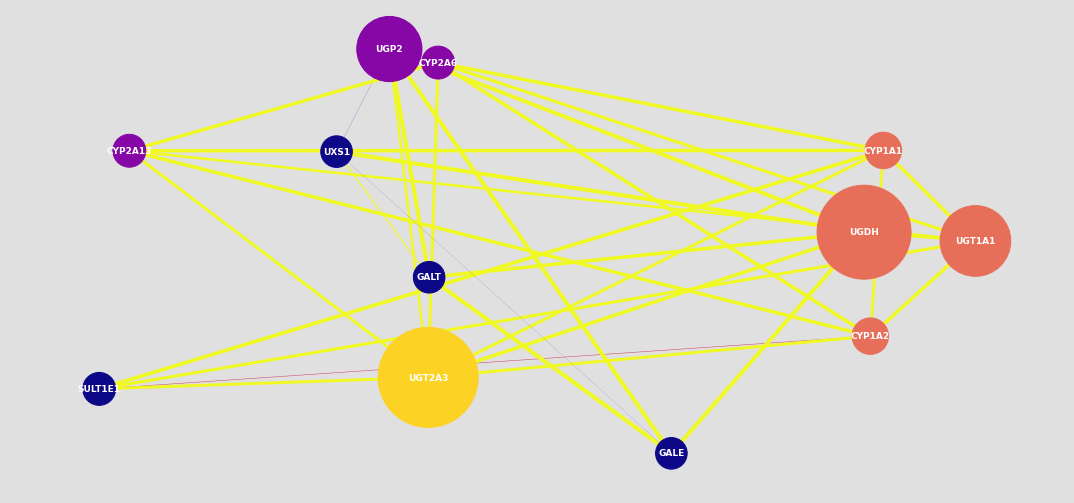

In [15]:
from graphviz import *
graph_colormap = cm.get_cmap('plasma', 12)
# cor do vertice varia de acordo com o grau
c = rescale([G2.degree(v) for v in G2],0.0,0.9) 
c = [graph_colormap(i) for i in c]
# tamanho do vertice varia de acordo com a centralidade
bc = nx.betweenness_centrality(G2) # betweeness centrality
s =  rescale([v for v in bc.values()], 1000, 10000)
# converter o peso da aresta em força de interação (para medida de centralidade)
ew = rescale([float(G2[u][v]['weight']) for u,v in G2.edges], 0.1,4)
# cor das arestas de acordo com seu peso
ec = rescale([float(G2[u][v]['weight']) for u,v in G2.edges],0.1,4)
ec = [graph_colormap(i) for i in ec]
# montar grafo
pos = nx.random_layout(G2)
plt.figure(figsize=(19,9),facecolor=[0.7,0.7,0.7,0.4])
nx.draw_networkx(G2, pos=pos, with_labels=True, node_color=c, node_size=s,edge_color= ec,width=ew,
                 font_color='white',font_weight='bold',font_size='9')
plt.axis('off')
plt.show()

#### Referência NCBI: https://www.ncbi.nlm.nih.gov/books/NBK25501/

#### Referência Biopython: http://biopython.org/DIST/docs/tutorial/Tutorial.html